In [1]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

In [3]:
rdrive = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/'
results_dir = rdrive + 'processed_results/'
mll_gam = rdrive + 'mll/gam_spec/'
mll_nuc = rdrive + 'mll/nuc_conc/'
learn_gam = rdrive + 'scikit/gam_spec/'
learn_nuc = rdrive + 'scikit/nuc_conc/'
dets = ['nuc29', 'act32', 'act4/9', 'd1_hpge', 'd2_hpge', 'd3_czt', 'd6_sri2', 'd5_labr3', 'd4_nai']
pred = ['reactor', 'burnup', 'enrichment', 'cooling']
predmll = ['ReactorType', 'Burnup', 'Enrichment', 'CoolingTime']
cm_labels = ['bwr', 'pwr', 'phwr']

In [61]:
def plot_cm(cm_list, descrip):
    plt.clf()
    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(18,6))
    titles = ['MLL', 'kNN', 'DTree']
    for a, ax in enumerate(axs):
        cm = cm_list[a].plot(ax=ax)
        ax.xaxis.label.set_size(16)
        ax.yaxis.label.set_size(16)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.set_title(titles[a] + descrip, fontsize=20)
    plt.show()
    
    sv_fig = './plots/confusion_matrix_auto_d1.png'
    fig.savefig(sv_fig, bbox_inches='tight', transparent=True)
    return

# Confusion Matrix for Reactor Type Results

### act32 case

In [11]:
mll_a32 = pd.read_csv(mll_gam + 'act32/Job0_unc0.05/Job0_unc0.05.csv')
knn_a32 = pd.read_csv(learn_gam + 'test_0.067_only/act32/reactor_knn_tset1.0_act32_mimic_mll.csv')
dtr_a32 = pd.read_csv(learn_gam + 'test_0.067_only/act32/reactor_dtree_tset1.0_act32_mimic_mll.csv')

In [12]:
mll_cm = confusion_matrix(mll_a32[predmll[0]], mll_a32['pred_' + predmll[0]], labels=cm_labels, normalize='true')
mll_cm = ConfusionMatrixDisplay(confusion_matrix=mll_cm, display_labels=cm_labels)
knn_cm = confusion_matrix(knn_a32['TrueY'], knn_a32['kNN'], labels=cm_labels, normalize='true')
knn_cm = ConfusionMatrixDisplay(confusion_matrix=knn_cm, display_labels=cm_labels)
dtr_cm = confusion_matrix(dtr_a32['TrueY'], dtr_a32['DTree'], labels=cm_labels, normalize='true')
dtr_cm = ConfusionMatrixDisplay(confusion_matrix=dtr_cm, display_labels=cm_labels)

<Figure size 432x288 with 0 Axes>

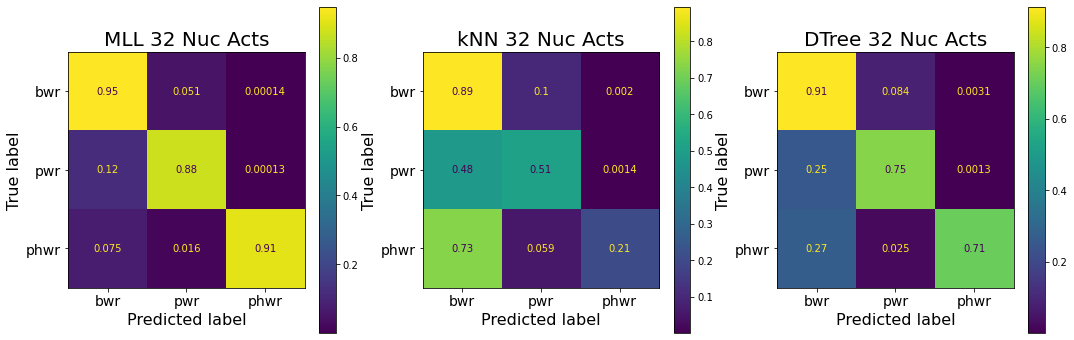

In [58]:
plot_cm([mll_cm, knn_cm, dtr_cm], ' 32 Nuc Acts')

### lab HPGe (d1) n31 case

In [51]:
mll_n31 = pd.read_csv(mll_gam + 'd1_n31/Job1_unc0.0/Job1_unc0.0.csv')
knn_n31 = pd.read_csv(learn_gam + 'test_0.067_only/n31/reactor_knn_tset1.0_d1_hpge_mimic_mll.csv')
dtr_n31 = pd.read_csv(learn_gam + 'test_0.067_only/n31/reactor_dtree_tset1.0_d1_hpge_mimic_mll.csv')

In [52]:
mll_cm = confusion_matrix(mll_n31[predmll[0]], mll_n31['pred_' + predmll[0]], labels=cm_labels, normalize='true')
mll_cm = ConfusionMatrixDisplay(confusion_matrix=mll_cm, display_labels=cm_labels)
knn_cm = confusion_matrix(knn_n31['TrueY'], knn_n31['kNN'], labels=cm_labels, normalize='true')
knn_cm = ConfusionMatrixDisplay(confusion_matrix=knn_cm, display_labels=cm_labels)
dtr_cm = confusion_matrix(dtr_n31['TrueY'], dtr_n31['DTree'], labels=cm_labels, normalize='true')
dtr_cm = ConfusionMatrixDisplay(confusion_matrix=dtr_cm, display_labels=cm_labels)

<Figure size 432x288 with 0 Axes>

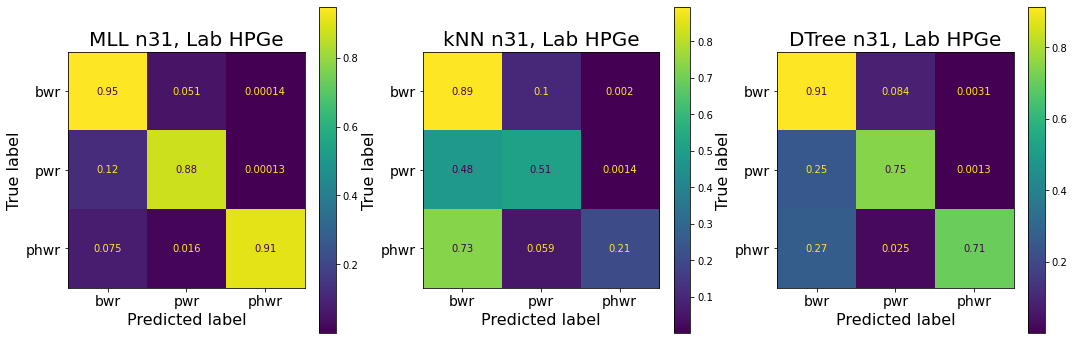

In [60]:
plot_cm([mll_cm, knn_cm, dtr_cm], ' n31, Lab HPGe')

### lab HPGe (d1) auto case

In [54]:
mll_auto = pd.read_csv(mll_gam + 'd1_auto/Job1_unc0.0/Job1_unc0.0.csv')
knn_auto = pd.read_csv(learn_gam + 'test_0.067_only/auto/reactor_knn_tset1.0_d1_hpge_mimic_mll.csv')
dtr_auto = pd.read_csv(learn_gam + 'test_0.067_only/auto/reactor_dtree_tset1.0_d1_hpge_mimic_mll.csv')

In [55]:
mll_cm = confusion_matrix(mll_auto[predmll[0]], mll_auto['pred_' + predmll[0]], labels=cm_labels, normalize='true')
mll_cm = ConfusionMatrixDisplay(confusion_matrix=mll_cm, display_labels=cm_labels)
knn_cm = confusion_matrix(knn_auto['TrueY'], knn_auto['kNN'], labels=cm_labels, normalize='true')
knn_cm = ConfusionMatrixDisplay(confusion_matrix=knn_cm, display_labels=cm_labels)
dtr_cm = confusion_matrix(dtr_auto['TrueY'], dtr_auto['DTree'], labels=cm_labels, normalize='true')
dtr_cm = ConfusionMatrixDisplay(confusion_matrix=dtr_cm, display_labels=cm_labels)

<Figure size 432x288 with 0 Axes>

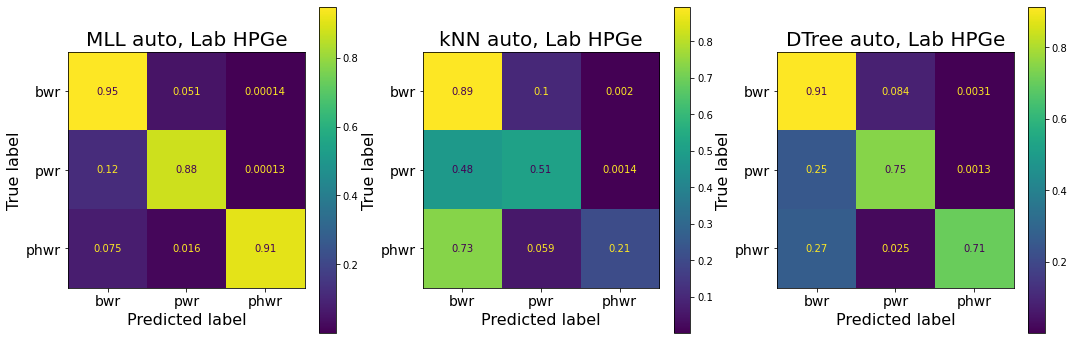

In [62]:
plot_cm([mll_cm, knn_cm, dtr_cm], ' auto, Lab HPGe')